copied from https://www.kaggle.com/tatudoug/stock-embedding-ffnn-my-features

- cluster N=5 LB:
- cluster N=7 LB: 0.19758

In [1]:
from IPython.core.display import display, HTML

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob, joblib, os, gc

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import seaborn as sns
import numpy.matlib

from sklearn.model_selection import KFold,GroupShuffleSplit

import lightgbm as lgb
from tqdm.auto import tqdm

from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline


path_submissions = '/'

target_name = 'target'
scores_folds = {}

In [2]:
# data directory
data_dir = '../input/optiver-realized-volatility-prediction/'

# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def calc_wap3(df):
    wap = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap4(df):
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# Function to calculate the log of the return
# Remember that logb(x / y) = logb(x) - logb(y)
def log_return(series):
    return np.log(series).diff()

# Calculate the realized volatility
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

# Function to read our base train and test set
def read_train_test():
    train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    return train, test

# Function to preprocess book data (for each stock id)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    df['wap3'] = calc_wap3(df)
    df['wap4'] = calc_wap4(df)
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    df['log_return3'] = df.groupby(['time_id'])['wap3'].apply(log_return)
    df['log_return4'] = df.groupby(['time_id'])['wap4'].apply(log_return)
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['volume'] = df['ask_size1'] + df['bid_size1'] 
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    # Dict for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.std],
        'wap2': [np.sum, np.std],
        'wap3': [np.sum, np.std],
        'wap4': [np.sum, np.std],
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
        'wap_balance': [np.sum, np.max],
        'price_spread':[np.sum, np.max],
        'price_spread2':[np.sum, np.max],
        'bid_spread':[np.sum, np.max],
        'ask_spread':[np.sum, np.max],
        'volume': [np.mean, np.max ],
        'total_volume':[np.mean, np.max],
        'volume_imbalance':[np.sum, np.max],
        "bid_ask_spread":[np.sum,  np.max],
    }
    create_feature_dict_time = {
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id__100'], axis = 1, inplace = True)
    
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.rename(columns={"time_id_":"time_id"},inplace=True)
    #___________________________________________________________________
    # create quantiles statistics for log_return1
     # [0.75, 0.95, 0.96, 0.97, 0.98, 0.99]
    quant_levels = [0.65, 0.75, 0.85, 0.95, 0.96, 0.97, 0.98, 0.99]
    df_sub= df.loc[df.log_return1.abs()>0.0000001, ['time_id', 'log_return1']].abs()
    df_quant =df_sub.groupby(['time_id']).quantile(quant_levels).reset_index(level=[0,1])
    df_quant = df_quant.pivot(index='time_id', columns='level_1', values=[ 'log_return1'])
    df_quant.columns = [str(col[1]) for col in df_quant.columns ]
    df_quant.reset_index(level='time_id',inplace=True)

    for q in df_quant.columns[1:]:
        df_sub_1 =  pd.merge(df_sub, df_quant[['time_id',q]], on='time_id')
        df_sub_1 = df_sub_1.loc[df_sub_1['log_return1']<df_sub_1[q]]
        df_sub_1 = df_sub_1.groupby('time_id').agg({'log_return1': [realized_volatility]})
        df_sub_1.columns = ['log_return1_realized_volatility_quantile' +'_'+ q] # rename columns
        df_sub_1.reset_index(inplace=True)
        df_feature = df_feature.merge(df_sub_1, on='time_id')
    # add quantile of 101, 105
    df_feature['log_return1_RV_1.01'] = np.sqrt(2*df_feature['log_return1_realized_volatility']**2 
                                                              - df_feature['log_return1_realized_volatility_quantile_0.99']**2)
    df_feature['log_return1_RV_1.02'] = np.sqrt(2*df_feature['log_return1_realized_volatility']**2 
                                                              - df_feature['log_return1_realized_volatility_quantile_0.98']**2)
    df_feature['log_return1_RV_1.10'] = np.sqrt(df_feature['log_return1_realized_volatility']**2 
                                                              + df_feature['log_return1_realized_volatility_quantile_0.85']**2 
                                                              - df_feature['log_return1_realized_volatility_quantile_0.75']**2)
    df_feature['log_return1_RV_quantile_1.101'] = np.sqrt(df_feature['log_return1_realized_volatility']**2 
                                                              + df_feature['log_return1_realized_volatility_quantile_0.75']**2 
                                                              - df_feature['log_return1_realized_volatility_quantile_0.65']**2)
    df_feature.drop(['time_id'], axis = 1, inplace = True)
    
    return df_feature

# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    df['amount']=df['price']*df['size']
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.mean, np.max, np.min],
        'order_count':[np.sum,np.max],
        'amount':[np.sum,np.max,np.min],
    }
    create_feature_dict_time = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.sum],
    }
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    

    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)
    
    def tendency(price, vol):    
        df_diff = np.diff(price)
        val = (df_diff/price[1:])*100
        power = np.sum(val*vol[1:])
        return(power)
    
    lis = []
    for n_time_id in df['time_id'].unique():
        df_id = df[df['time_id'] == n_time_id]        
        tendencyV = tendency(df_id['price'].values, df_id['size'].values)      
        f_max = np.sum(df_id['price'].values > np.mean(df_id['price'].values))
        f_min = np.sum(df_id['price'].values < np.mean(df_id['price'].values))
        df_max =  np.sum(np.diff(df_id['price'].values) > 0)
        df_min =  np.sum(np.diff(df_id['price'].values) < 0)
        # new
        abs_diff = np.median(np.abs( df_id['price'].values - np.mean(df_id['price'].values)))        
        energy = np.mean(df_id['price'].values**2)
        iqr_p = np.percentile(df_id['price'].values,75) - np.percentile(df_id['price'].values,25)
        
        # vol vars
        
        abs_diff_v = np.median(np.abs( df_id['size'].values - np.mean(df_id['size'].values)))        
        energy_v = np.sum(df_id['size'].values**2)
        iqr_p_v = np.percentile(df_id['size'].values,75) - np.percentile(df_id['size'].values,25)
        
        lis.append({'time_id':n_time_id,'tendency':tendencyV,'f_max':f_max,'f_min':f_min,'df_max':df_max,'df_min':df_min,
                   'abs_diff':abs_diff,'energy':energy,'iqr_p':iqr_p,'abs_diff_v':abs_diff_v,'energy_v':energy_v,'iqr_p_v':iqr_p_v})
    
    df_lr = pd.DataFrame(lis)
        
   
    df_feature = df_feature.merge(df_lr, how = 'left', left_on = 'time_id_', right_on = 'time_id')
    
    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id','time_id__100'], axis = 1, inplace = True)
    
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_400', 'log_return2_realized_volatility_400', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_200', 'log_return2_realized_volatility_200', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_400', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_200']


    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df
 
   


# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    df['size_r1']= df['volume_mean']/ df['trade_size_mean']
    df['size_r2']= df['total_volume_mean']/ df['trade_size_mean']
    df['r1_r2'] = df.size_r2/df.size_r1
    return df

# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False


# Function to plot feature importance
def plot_feature_importance(model, max_feas=30): # show at most max_feas in the bar plot
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(importance_type='split'),
                                          model.feature_name()), reverse=True), columns=['Value','Feature'])
    #print(feature_imp.loc[:30])
    # df.sort_values(by="Value", ascending=False)
    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.iloc[:max_feas])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

In [3]:
new_features = False
submit = False
if new_features:
    # Read train and test
    train, test = read_train_test()

    # Get unique stock ids 
    train_stock_ids = train['stock_id'].unique()
    # Preprocess them using Parallel and our single stock id functions
    train_ = preprocessor(train_stock_ids, is_train = True)
    train = train.merge(train_, on = ['row_id'], how = 'left')
    train.to_parquet('train.parquet')
else:
    train = pd.read_parquet('../input/optiverfeatures/train.parquet')
    
if submit:
    _, test = read_train_test()
    # Get unique stock ids 
    test_stock_ids = test['stock_id'].unique()
    # Preprocess them using Parallel and our single stock id functions
    test_ = preprocessor(test_stock_ids, is_train = False)
    test = test.merge(test_, on = ['row_id'], how = 'left')
    ## save processed train/test
    test.to_parquet('test.parquet')
else:
    test = pd.read_parquet('../input/optiverfeatures/test.parquet')





# feature selection
Done in another notebook

In [4]:
def add_stock_todf(train, test):
    vol_cols = ['time_id','trade_log_return_realized_volatility_400', 'r1_r2', 'log_return3_realized_volatility_500', 'log_return1_realized_volatility_300', 
                     'trade_order_count_sum_500', 'bid_spread_amax', 'size_r2', 'volume_mean', 'trade_df_max', 'trade_iqr_p_v', 'trade_tendency', 'bid_ask_spread_sum', 'stock_id', 
                     'log_return4_realized_volatility_400', 'trade_size_amax', 'ask_spread_sum', 'wap1_sum', 'price_spread_amax', 
                     'log_return1_RV_1.10', 'price_spread2_sum', 'price_spread2_amax', 'trade_size_mean', 'volume_amax', 'wap2_std', 
                     'wap3_std', 'trade_amount_amin', 'trade_order_count_sum_100', 'trade_df_min', 'total_volume_amax', 'trade_log_return_realized_volatility_500', 
                     'total_volume_mean', 'trade_order_count_amax', 'price_spread_sum', 'trade_order_count_sum_200', 'trade_order_count_sum_400', 
                     'log_return1_realized_volatility_200', 'trade_log_return_realized_volatility_300', 'ask_spread_amax', 'log_return4_realized_volatility_500',
                     'wap2_sum', 'log_return1_realized_volatility_quantile_0.65', 'trade_abs_diff_v', 'volume_imbalance_amax', 'log_return3_realized_volatility_300', 
                     'trade_order_count_sum_300', 'log_return2_realized_volatility_300', 'trade_size_sum_500', 'wap_balance_sum', 'size_r1', 'bid_spread_sum',
                     'log_return2_realized_volatility', 'trade_energy', 'log_return2_realized_volatility_400', 'trade_log_return_realized_volatility', 
                     'log_return2_realized_volatility_200']

    def add_stock(df, stock_id):

        df_sub = df[df['stock_id']==stock_id][vol_cols].reset_index(drop=True)
        # rename the columns
        df_sub.columns = ['time_id']+[name +'_'+ str(stock_id) for name in vol_cols[1:]]
        return df_sub

    df_sub = Parallel(n_jobs = -1, verbose = 1)(delayed(add_stock)(train, stock_id) for stock_id in [3,8,18,20,31,37,43,58,80,81,95,103,110,123])
    # Merge with original dataframe
    for i in range(len(df_sub)):
        train = train.merge(df_sub[i], how = 'left', on = ['time_id'])
    train.to_parquet('train.parquet')
    print(train.shape)

    df_sub = Parallel(n_jobs = -1, verbose = 1)(delayed(add_stock)(test, stock_id) for stock_id in [3,8,18,20,31,37,43,58,80,81,95,103,110,123])
    # Merge with original dataframe
    for i in range(len(df_sub)):
        test = test.merge(df_sub[i], how = 'left', on = ['time_id'])
    test.to_parquet('test.parquet')
    print(test.shape)

    del vol_cols, df_sub
    
add_stock_todf(train, test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    3.4s finished


(428932, 880)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.1s finished


(3, 879)


In [5]:
def train_and_evaluate(train, test):
    # Hyperparammeters  https://github.com/microsoft/LightGBM/blob/master/docs/Parameters.rst
    seed = 11111
    params = {
        'objective': 'mse',  # use mape closer to the competetion metric
        'boosting': 'gbdt', #dart
        'linear_tree': False, #never works well
        'drop_rate': 0.1,
        'num_iterations': 2000,
        'learning_rate': 0.1,        
        'lambda_l1': 1, # l1 regulariztion to achieve sparsity
        'lambda_l2': 1,
        'num_leaves': 256,  #128  #2^5=32
        'feature_fraction': 0.66, # 0.62
        'feature_fraction_bynode': 1,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 2, #20
        'max_depth': 5, # decrease if overfitting
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
        'verbosity': -1,
        'n_jobs': -1,
    }  
    # make y larger so that the loss is not too small
    SCALE =1000
    # Split features and target
    x = train.drop(['row_id', 'target', 'time_id'], axis = 1)
    y = train['target']*SCALE
    x_test = test.drop(['row_id', 'time_id'], axis = 1)
    # Transform stock id to a numeric value
    x['stock_id'] = x['stock_id'].astype(int)
    x_test['stock_id'] = x_test['stock_id'].astype(int)
    
    # normalize 
#     Mean, Std = x.mean(), x.std()
#     x = (x-Mean)/Std * SCALE
#     x_test = (x_test-Mean)/Std *SCALE
  
    
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(x_test.shape[0])
    # Create a KFold object
    kfold = GroupShuffleSplit(n_splits=5, train_size=.8, random_state=42).split(x, y, groups=train.time_id)

    # KFold(n_splits = 5, random_state = 142, shuffle = True).split(x)
    # Iterate through each fold


    for fold, (trn_ind, val_ind) in enumerate(tqdm(kfold)):
        print(f'Training fold {fold}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ['stock_id'])
        val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ['stock_id'])
        
        model = lgb.train(params = params, 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          early_stopping_rounds = 50, 
                          verbose_eval = 50,
                          feval = feval_rmspe)
        print(f'model_fold{fold} saving!')
        # feature importance
        plot_feature_importance(model)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val)
        # save model
        joblib.dump(model, f'model_fold{fold}.pkl')
        
        # Predict the test set
        test_predictions += model.predict(x_test, predict_disable_shape_check=True) / (fold+1)
        
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    # Return test predictions
    return test_predictions/SCALE



In [6]:
TRAIN = True
if TRAIN:
    train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')

train.replace([np.inf, -np.inf], np.nan,inplace=True)
test.replace([np.inf, -np.inf], np.nan,inplace=True)

0it [00:00, ?it/s]

Training fold 0


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.205767	training's RMSPE: 0.209092	valid_1's l2: 0.216551	valid_1's RMSPE: 0.21881
[100]	training's l2: 0.185127	training's RMSPE: 0.198329	valid_1's l2: 0.214635	valid_1's RMSPE: 0.21784
[150]	training's l2: 0.173426	training's RMSPE: 0.191958	valid_1's l2: 0.215182	valid_1's RMSPE: 0.218118
Early stopping, best iteration is:
[103]	training's l2: 0.184261	training's RMSPE: 0.197864	valid_1's l2: 0.214254	valid_1's RMSPE: 0.217647
model_fold0 saving!


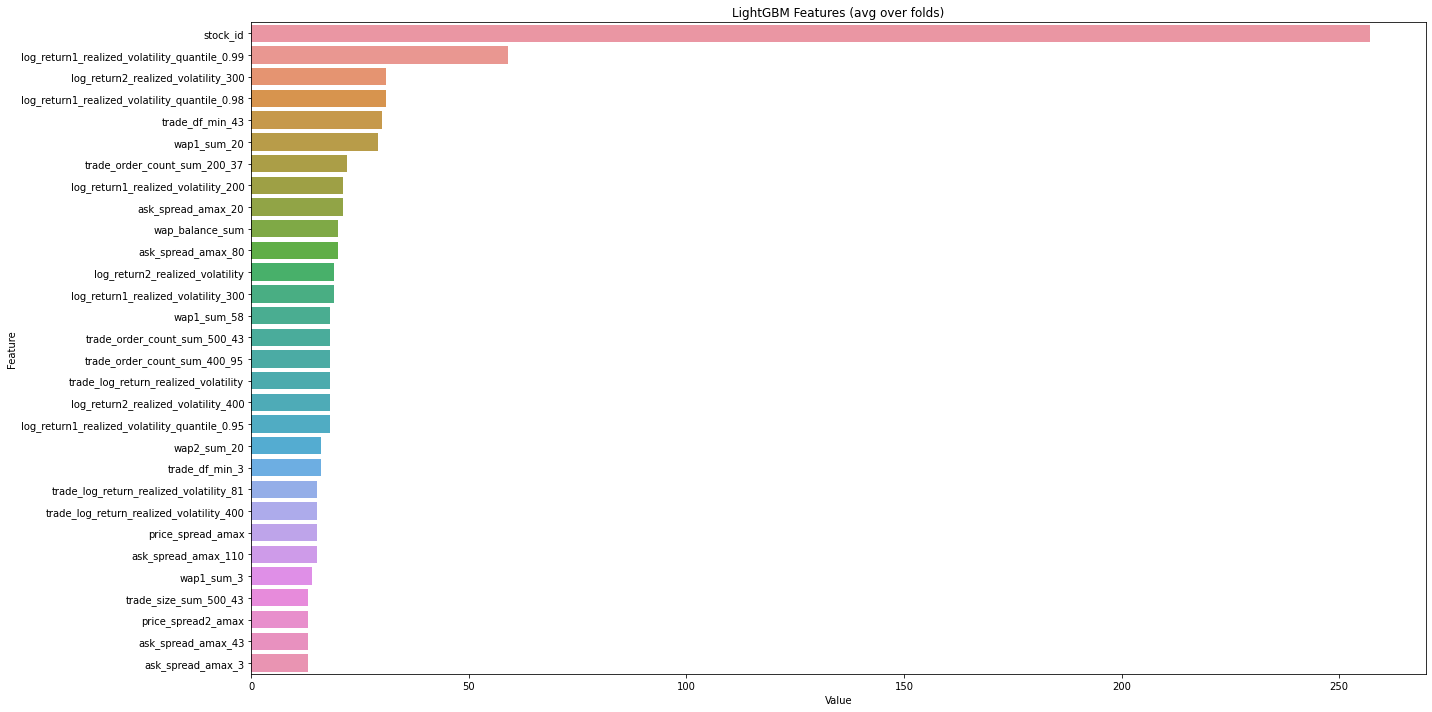

Training fold 1


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.202254	training's RMSPE: 0.209008	valid_1's l2: 0.229167	valid_1's RMSPE: 0.217815
[100]	training's l2: 0.181892	training's RMSPE: 0.198209	valid_1's l2: 0.225894	valid_1's RMSPE: 0.216254
[150]	training's l2: 0.170234	training's RMSPE: 0.191751	valid_1's l2: 0.224379	valid_1's RMSPE: 0.215528
[200]	training's l2: 0.162347	training's RMSPE: 0.187257	valid_1's l2: 0.223799	valid_1's RMSPE: 0.215249
[250]	training's l2: 0.156264	training's RMSPE: 0.183715	valid_1's l2: 0.222751	valid_1's RMSPE: 0.214744
[300]	training's l2: 0.151141	training's RMSPE: 0.180678	valid_1's l2: 0.222222	valid_1's RMSPE: 0.214489
[350]	training's l2: 0.14722	training's RMSPE: 0.17832	valid_1's l2: 0.221858	valid_1's RMSPE: 0.214313
[400]	training's l2: 0.143541	training's RMSPE: 0.176077	valid_1's l2: 0.221422	valid_1's RMSPE: 0.214102
Early stopping, best iteration is:
[392]	training's l2: 0.14406	training's RMSPE: 0.176395	val

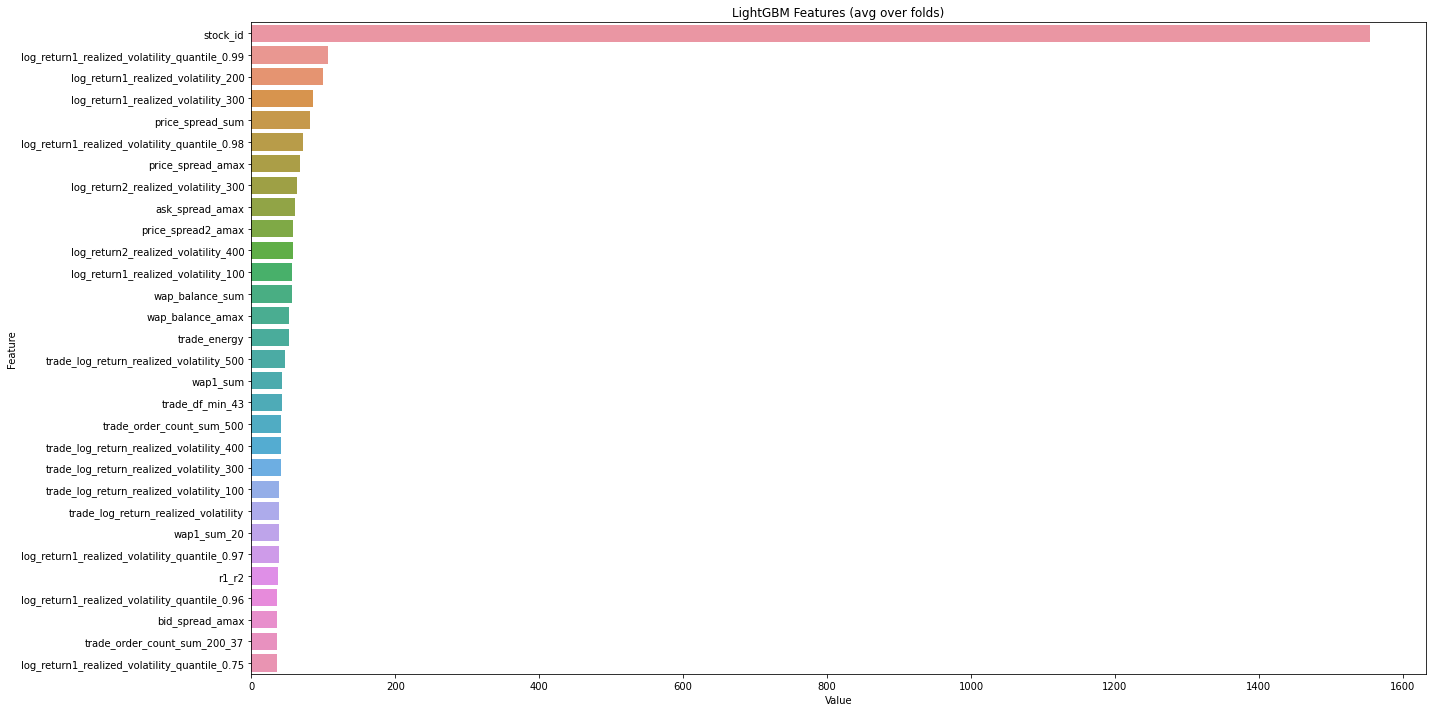

Training fold 2


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.204234	training's RMSPE: 0.208157	valid_1's l2: 0.229529	valid_1's RMSPE: 0.225914
[100]	training's l2: 0.184627	training's RMSPE: 0.197913	valid_1's l2: 0.227891	valid_1's RMSPE: 0.225107
[150]	training's l2: 0.173555	training's RMSPE: 0.191887	valid_1's l2: 0.226586	valid_1's RMSPE: 0.224461
[200]	training's l2: 0.16518	training's RMSPE: 0.1872	valid_1's l2: 0.225277	valid_1's RMSPE: 0.223812
[250]	training's l2: 0.15918	training's RMSPE: 0.183769	valid_1's l2: 0.224478	valid_1's RMSPE: 0.223415
[300]	training's l2: 0.154226	training's RMSPE: 0.180886	valid_1's l2: 0.224119	valid_1's RMSPE: 0.223236
[350]	training's l2: 0.15	training's RMSPE: 0.178391	valid_1's l2: 0.223629	valid_1's RMSPE: 0.222992
Early stopping, best iteration is:
[338]	training's l2: 0.150905	training's RMSPE: 0.178928	valid_1's l2: 0.22339	valid_1's RMSPE: 0.222873
model_fold2 saving!


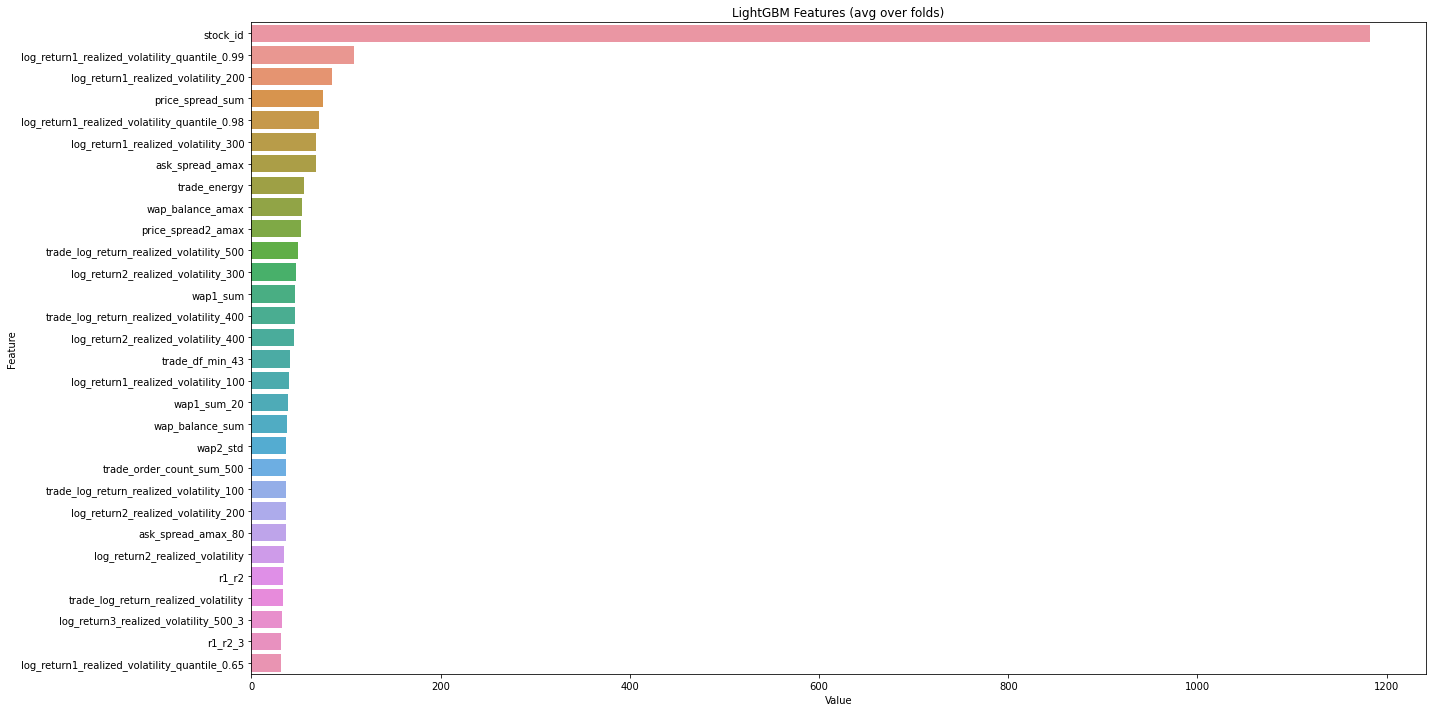

Training fold 3


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.201281	training's RMSPE: 0.208271	valid_1's l2: 0.22765	valid_1's RMSPE: 0.218106
[100]	training's l2: 0.181818	training's RMSPE: 0.197946	valid_1's l2: 0.223187	valid_1's RMSPE: 0.215958
[150]	training's l2: 0.170505	training's RMSPE: 0.191688	valid_1's l2: 0.220124	valid_1's RMSPE: 0.214471
[200]	training's l2: 0.163464	training's RMSPE: 0.187689	valid_1's l2: 0.219306	valid_1's RMSPE: 0.214072
[250]	training's l2: 0.157132	training's RMSPE: 0.184018	valid_1's l2: 0.218881	valid_1's RMSPE: 0.213864
[300]	training's l2: 0.152027	training's RMSPE: 0.181004	valid_1's l2: 0.218449	valid_1's RMSPE: 0.213653
[350]	training's l2: 0.147778	training's RMSPE: 0.178457	valid_1's l2: 0.218473	valid_1's RMSPE: 0.213665
[400]	training's l2: 0.144161	training's RMSPE: 0.176259	valid_1's l2: 0.218108	valid_1's RMSPE: 0.213487
[450]	training's l2: 0.141043	training's RMSPE: 0.174343	valid_1's l2: 0.218678	valid_1's RMS

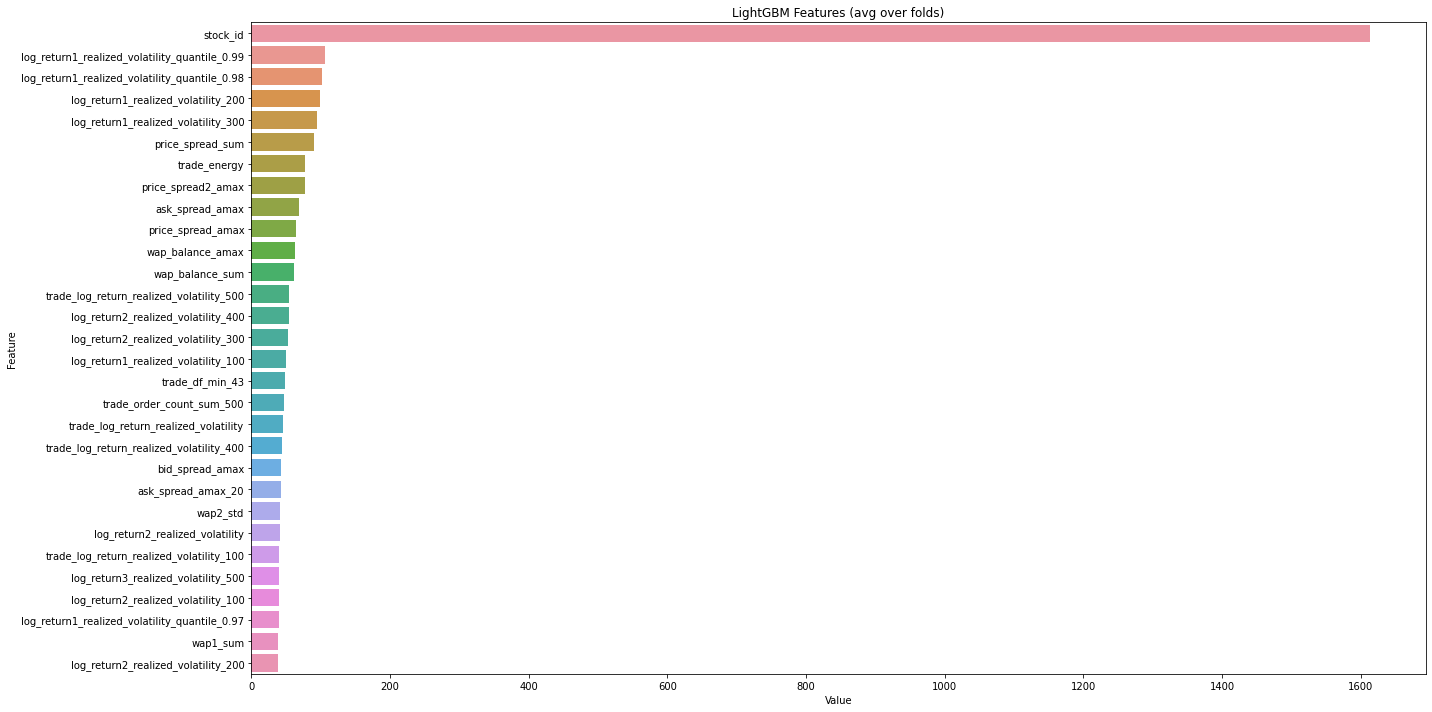

Training fold 4


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.200711	training's RMSPE: 0.207696	valid_1's l2: 0.250995	valid_1's RMSPE: 0.230286
[100]	training's l2: 0.181319	training's RMSPE: 0.197407	valid_1's l2: 0.247714	valid_1's RMSPE: 0.228776
[150]	training's l2: 0.17026	training's RMSPE: 0.191293	valid_1's l2: 0.24597	valid_1's RMSPE: 0.227969
[200]	training's l2: 0.162387	training's RMSPE: 0.186817	valid_1's l2: 0.245546	valid_1's RMSPE: 0.227772
Early stopping, best iteration is:
[183]	training's l2: 0.1649	training's RMSPE: 0.188258	valid_1's l2: 0.245274	valid_1's RMSPE: 0.227646
model_fold4 saving!


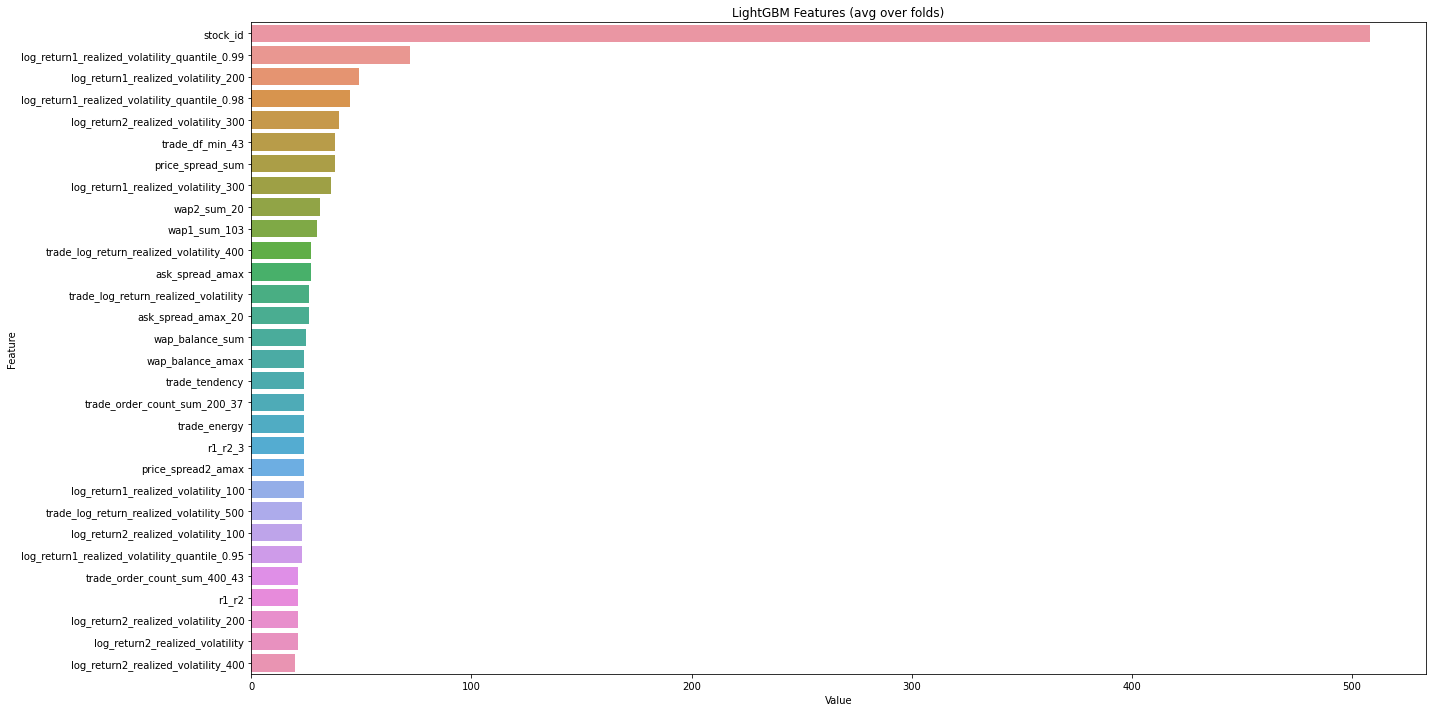

Our out of folds RMSPE is 0.607348107621763


NameError: name 'test_id' is not defined

In [7]:

Saved = True
MODEL_DIR = '../input/optiver-models'
if TRAIN:
    test_predictions = train_and_evaluate(train, test)
else:    
    """
    INFERENCE and submisstion only
    """
    SCALE =1000
    
    test_id = test[['row_id', 'time_id']]
    test.drop(['row_id', 'time_id'], axis = 1, inplace=True)
    # Transform stock id to a numeric value
    test['stock_id'] = test['stock_id'].astype(int)

    test_predictions = np.zeros(len(test))
    files = glob.glob(f'{MODEL_DIR}/*model*.pkl')
    for i, f in enumerate(files):
        model = joblib.load(f)
        test_predictions += model.predict(test, predict_disable_shape_check=True)
        #plot_feature_importance(model)
    test_predictions /= (i+1)*SCALE
    
# Save test predictions
test['target'] = test_predictions
test['row_id'] = test_id['row_id']
test[['row_id', 'target']].to_csv('submission.csv',index = False)
print('submission saved!') 

In [ ]:
#colNames.remove('row_id')

qt_train = []
train_nn=train[colNames].copy()
test_nn=test[colNames].copy()
for col in colNames:
    #print(col)
    qt = QuantileTransformer(random_state=21,n_quantiles=2000, output_distribution='normal')
    train_nn[col] = qt.fit_transform(train_nn[[col]])
    test_nn[col] = qt.transform(test_nn[[col]])    
    qt_train.append(qt)
